## Import libs, set paths and load params

In [1]:
import os, glob
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../src")
import auxilary_functions as f
import subprocess
import csv
import matplotlib.pyplot as plt

cfg = f.get_actual_parametrization("../src/config.json")
networks = ['gnw','networkx','fflatt']
networks = ['gnw']
organisms = ['ecoli','yeast','mouse','human']
organisms = ['ecoli']
#ffl_percentages = ['0.374', '0.270', '0.315', '0.347']
ffl_percentages = ['0.13'] #use 0.13
ffl_percentages = ['0.374']
#sizes = ['250','500','750', '999']
sizes = ['500', '750', '1000', '1500']
#sizes = ['250']
n_trials = 10

os.chdir('../networks/')
gnwdir = '/home/erik/sweden/sonnhammer/gnw/'
fflattdir = '../snippets/'

In [2]:
print(os.getcwd())
current_dir = os.path.join(os.getcwd())

/home/erik/sweden/sonnhammer/GeneSnake/generation/network_generation_algo/networks


In [3]:
# for rep, file in enumerate(glob.glob(os.path.join(current_dir, '*.tsv'))):
#     print(rep, file)
#     print(f.analyze_exctracted_network(cfg, file, 'networkx', rep, str(1500)))

In [4]:
#collect data
topo_list = []
for network in networks:
    for number, organism in enumerate(organisms):
        for size in sizes:
            current_dir = os.path.join(os.getcwd(), network, organism, size)
            #create networks if don't exist
            if not os.path.exists(os.path.abspath(current_dir)):
                
                try:
                    print('making dirs...')
                    os.mkdir(os.path.abspath(current_dir))
                        
                except FileExistsError:
                    pass
                
                if network == 'gnw':
                    
                    print('running gnw...')
                    subprocess.call(['java', '-jar', gnwdir+'gnw-3.1.2b.jar', '--extract', '--input-net',\
                         gnwdir+'sandbox/ecoli_transcriptional_network_regulonDB_6_7.tsv',\
                        '--random-seed', '--greedy-selection', '--subnet-size='+str(size),\
                        '--num-subnets='+str(n_trials), '--output-net-format=0', '--keep-self-interactions',\
                        '-c', 'sandbox/settings.txt', '--output-path',\
                        str(current_dir)])
                 
                elif network == 'networkx':
                    
                    print('creating scale-free networkx graphs...')       
                    f.create_nx_network(n_trials,cfg['SPARSITY'],size,current_dir)
                
                elif network == 'fflatt':
                    
                    print('running fflatt...')
                    #python3 test.py 103 0.4 test_networks/
                    subprocess.call(['python3', fflattdir+'test.py', size, ffl_percentages[number],\
                        str(n_trials), str(current_dir)])
                
                
                for rep, file in enumerate(glob.glob(os.path.join(current_dir, '*.tsv'))):
                    topo_list.append(f.analyze_exctracted_network(cfg, file, network, rep, size))
            
            #collect data otherwise
            else:
                for rep, file in enumerate(glob.glob(os.path.join(current_dir, '*.tsv'))):
                    topo_list.append(f.analyze_exctracted_network(cfg, file, network, rep, size))



In [5]:
# import pandas as pd

# edges = pd.read_csv("/home/erik/sweden/sonnhammer/GeneSnake/generation/network_generation_algo/networks/gnw/ecoli/1500/ecoli_transcriptional_network_regulonDB_6_7-5.tsv", sep='\t') 
# edges.columns = ["tf", "tg", "strength"]
# edges = edges[["tf", "tg"]]

# edges['tf'].astype(str)
# edges['tg'].astype(str)
# edges.columns = ["tf", "tg"]
    
# nodes = sorted(np.unique(np.concatenate((edges.tf.unique(), edges.tg.unique()))))
# nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
# edges_ = edges.join(nodes, on="tf").join(nodes, on="tg", lsuffix="_tf", rsuffix="_tg")
# np_edges = edges_[["idx_tg", "idx_tf"]].values
# interaction_matrix = f.build_Tnet(np_edges, len(nodes))
#interaction_matrix.shape

In [6]:
topo_list

[[119, 1.716, 0.851, 0.865, 'gnw', '500', 0],
 [287, 2.634, 1.288, 1.346, 'gnw', '500', 1],
 [119, 1.716, 0.85, 0.866, 'gnw', '500', 2],
 [75, 1.77, 0.873, 0.897, 'gnw', '500', 3],
 [297, 2.508, 1.229, 1.279, 'gnw', '500', 4],
 [191, 1.717, 0.859, 0.858, 'gnw', '500', 5],
 [75, 1.77, 0.872, 0.898, 'gnw', '500', 6],
 [119, 1.716, 0.849, 0.867, 'gnw', '500', 7],
 [75, 1.77, 0.872, 0.898, 'gnw', '500', 8],
 [116, 1.71, 0.841, 0.869, 'gnw', '500', 9],
 [309, 2.097, 1.046, 1.051, 'gnw', '750', 0],
 [187, 1.799, 0.874, 0.925, 'gnw', '750', 1],
 [169, 1.685, 0.818, 0.868, 'gnw', '750', 2],
 [362, 2.463, 1.239, 1.224, 'gnw', '750', 3],
 [311, 1.979, 0.949, 1.029, 'gnw', '750', 4],
 [263, 1.937, 0.943, 0.995, 'gnw', '750', 5],
 [302, 1.996, 0.971, 1.025, 'gnw', '750', 6],
 [373, 2.479, 1.247, 1.232, 'gnw', '750', 7],
 [263, 2.043, 0.999, 1.044, 'gnw', '750', 8],
 [169, 1.847, 0.902, 0.945, 'gnw', '750', 9],
 [441, 2.311, 1.148, 1.163, 'gnw', '1000', 0],
 [590, 2.522, 1.265, 1.257, 'gnw', '1000'

## Plot for E.coli

In [5]:
df_topo = pd.DataFrame(topo_list, columns = ['ffl-nodes', 'sparsity', 'in-degree',\
                                             'out-degree', 'network', 'size', 'rep'])
df_topo["size"] = pd.to_numeric(df_topo["size"])

NameError: name 'df_topo' is not defined

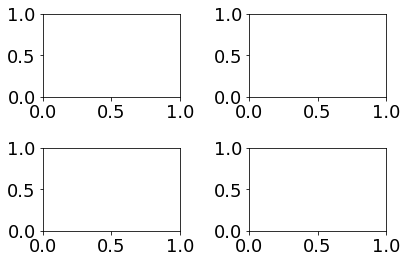

In [7]:
plt.rcParams.update({'font.size': 18})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout()

in_degree = df_topo[['size','in-degree', 'network']]
in_degree.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "in-degree", legend = False,\
         yerr = np.ravel(in_degree.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax3, cmap='Dark2', figsize = (17,12), title = 'In-degree')

out_degree = df_topo[['out-degree', 'network', 'size']]
out_degree.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "out-degree", legend = False,\
         yerr = np.ravel(out_degree.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax4, cmap='Dark2', figsize = (17,12), title = 'Out-degree')

sparsity = df_topo[['sparsity', 'network', 'size']]
sparsity.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "sparsity", legend = False,\
         yerr = np.ravel(sparsity.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax2, cmap='Dark2', figsize = (17,12), title = 'Sparsity')

ffl_nodes = df_topo[['ffl-nodes', 'network', 'size']]
ffl_nodes.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "ffl-nodes", legend = False,\
         yerr = np.ravel(ffl_nodes.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax1, cmap='Dark2', figsize = (17,12), title = 'FFL-nodes perc')

ax1.legend(["FFLatt", "GNW", "NetworkX graph"])


In [212]:
# sparsity.groupby(["network", "size"]).agg(np.mean) - sparsity.groupby(["network", "size"]).agg(np.std)

sparsity
network size          
fflatt  100   2.388536
        250   2.396756
        500   2.398000
gnw     100   1.213026
        250   1.828446
        500   1.796740

In [208]:
# sparsity.groupby(["network", "size"]).agg(np.mean) + sparsity.groupby(["network", "size"]).agg(np.std)

sparsity
network size          
fflatt  100   2.395464
        250   2.397911
        500   2.398000
gnw     100   2.316974
        250   2.743554
        500   2.887927

## Plot for Yeast

## Plot for Mouse

## Plot for Human